**Course Number:** CSCA 5622  
**Semester:** Summer 2, 2024  
**Student Name:** Yuning Mu

### **1. Project Overview** {-}

**Topics and Goals**

   - **Project Topic:** 

     - This project will focus on predicting student performance based on various attributes such as demographic data, family background, and school-related factors.

     - **Type of Learning:** Supervised learning.

     - **Type of Task:** Regression task (predicting a student's final grade).

   - **Goal:** 

     - The goal of the project is to build a model that can predict student performance in terms of their final grade, helping educators identify students at risk of underperforming and provide timely interventions.


**Dataset Description**

  - **Data Source:** 

    - The dataset `student-mat.csv` is derived from a public dataset available on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Student+Performance), specifically in the subject of Mathematics.

  - **Description:** 

    - The dataset includes 396 student records with 30 features related to student achievement in secondary education, which include demographic, social, and school-related features, as well as student grades. The data was collected from two Portuguese high schools using school reports and questionnaires.

  - **Data Characteristics:** 

    - **Type:** Multivariate

    - **Subject Area:** Social Science

    - **Associated Tasks:** Regression
  
    - **Target Value:** G3 (final grade)

Importing necessary libraries:

In [40]:
import pandas as pd
import numpy as np
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from textwrap import wrap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

The following code snippet reads the dataset `student-mat.csv` and prints the first few rows to give an overview of the data structure.

The data contains 395 rows and 33 columns in total.

In [41]:
data = pd.read_csv('grade_data/student-mat.csv')

print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])

data.head()

Rows:     395
Columns:  33


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


The file `grade_data/mapping.py` maps the feature names in the dataset to their actual meanings, making it easier to interpret and understand future visualizations. Below is a sample structure of the mapping:

In [42]:
from grade_data.mapping import get_mapping

feature_mapping = get_mapping()
SAMPLE_SIZE = 3
# Now you can use the feature_mapping dictionary
for i, (key, value) in enumerate(feature_mapping.items()):
    print(f"{key}:")
    for k,v in value.items():
        print(f"    {k}: {v}")
    if i + 1 == SAMPLE_SIZE:
        break
print("... and more")

school:
    name: School
    description: Student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
    type: Categorical
    demographic: None
sex:
    name: Sex
    description: Student's sex (binary: 'F' - female or 'M' - male)
    type: Binary
    demographic: Sex
age:
    name: Age
    description: Student's age (numeric: from 15 to 22)
    type: Integer
    demographic: Age
... and more


### **2. Exploratory Data Analysis (EDA) and Data Cleaning** {-}

#### a. EDA

We can proceed with Exploratory Data Analysis (EDA). We will explore the data visually to understand the distribution of features, correlations between them, and the relationship between features and the target variable.

**Checking for Missing or NaN Values**

First, it's essential check if the dataset contains any missing or NaN values. Missing values can affect the performance of algorithms and might need to be handled appropriately. The following code checks for missing values in each column of the dataset.
There are no missing values or NaN values in the dataset.


In [43]:
missing_values = data.isnull().sum()

print("Are there missing values in any column?")
if missing_values.any():
    print("The following columns have missing values:")
    for column, value in missing_values[missing_values > 0].items():
        print(f"- {column}: {value} missing value(s)")
else:
    print("No missing values found")

print("\nAre there any NaN values in the dataset?")
if data.isnull().values.any():
    nan_columns = data.columns[data.isnull().any()]
    print(f"Yes, there are NaN values in the following columns: {list(nan_columns)}")
else:
    print("No, there are no NaN values in the dataset.")

Are there missing values in any column?
No missing values found

Are there any NaN values in the dataset?
No, there are no NaN values in the dataset.


**Checking for Duplicate Rows**

Next, we check for duplicate rows in the dataset. Duplicates can cause bias in the analysis and need to be addressed. The code checks for the number of duplicate rows, and if any are found, it removes them and provides the count of rows before and after the removal.


In [44]:
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows in the dataset: {duplicates}")

if duplicates > 0:
    data_cleaned = data.drop_duplicates()
    print(f"Number of rows after removing duplicates: {data_cleaned.shape[0]}")
else:
    print("No duplicates found.")


Number of duplicate rows in the dataset: 0
No duplicates found.


**Feature Distribution Analysis**

Understanding the distribution of each feature is crucial in data analysis, as it helps to identify patterns, outliers, and the overall spread of the data. In this section, we will plot the distribution of each feature in the dataset. For numerical features, we will use histograms, and for categorical features, we will use bar plots.


In [45]:
def plot_feature_distribution(data, feature_mapping, items_per_row=3):
    num_features = len(data.columns)
    num_rows = (num_features + items_per_row - 1) // items_per_row

    fig, axes = plt.subplots(nrows=num_rows, ncols=items_per_row, figsize=(20, num_rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        # Get the feature mapping details
        mapping = feature_mapping.get(column, {})
        title = mapping.get("name", column)
        description = mapping.get("description", "No description")
        
        # Plot based on feature type
        if data[column].dtype not in ['int64', 'float64']:
            sns.countplot(data[column], ax=axes[i], color='skyblue')
        else:
            sns.histplot(data[column], kde=True, ax=axes[i], color='skyblue')
        
        # Set title with mapping info
        axes[i].set_title("\n".join(wrap(description, 50)))
        axes[i].set_xlabel(title)
        axes[i].set_ylabel('Count')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

**Distribution of Numerical Features:**

The numerical features include:

- `age`: The age of the student.
- `Medu`: Mother's education level, represented numerically.
- `Fedu`: Father's education level, represented numerically.
- `traveltime`: Time it takes for the student to travel from home to school.
- `studytime`: Weekly study time.
- `failures`: Number of past class failures.
- `famrel`: Quality of family relationships.
- `freetime`: Free time after school.
- `goout`: Frequency of going out with friends.
- `Dalc`: Workday alcohol consumption.
- `Walc`: Weekend alcohol consumption.
- `health`: Current health status.
- `absences`: Number of school absences.
- `G1`: First period grade.
- `G2`: Second period grade.
- `G3`: Final grade.

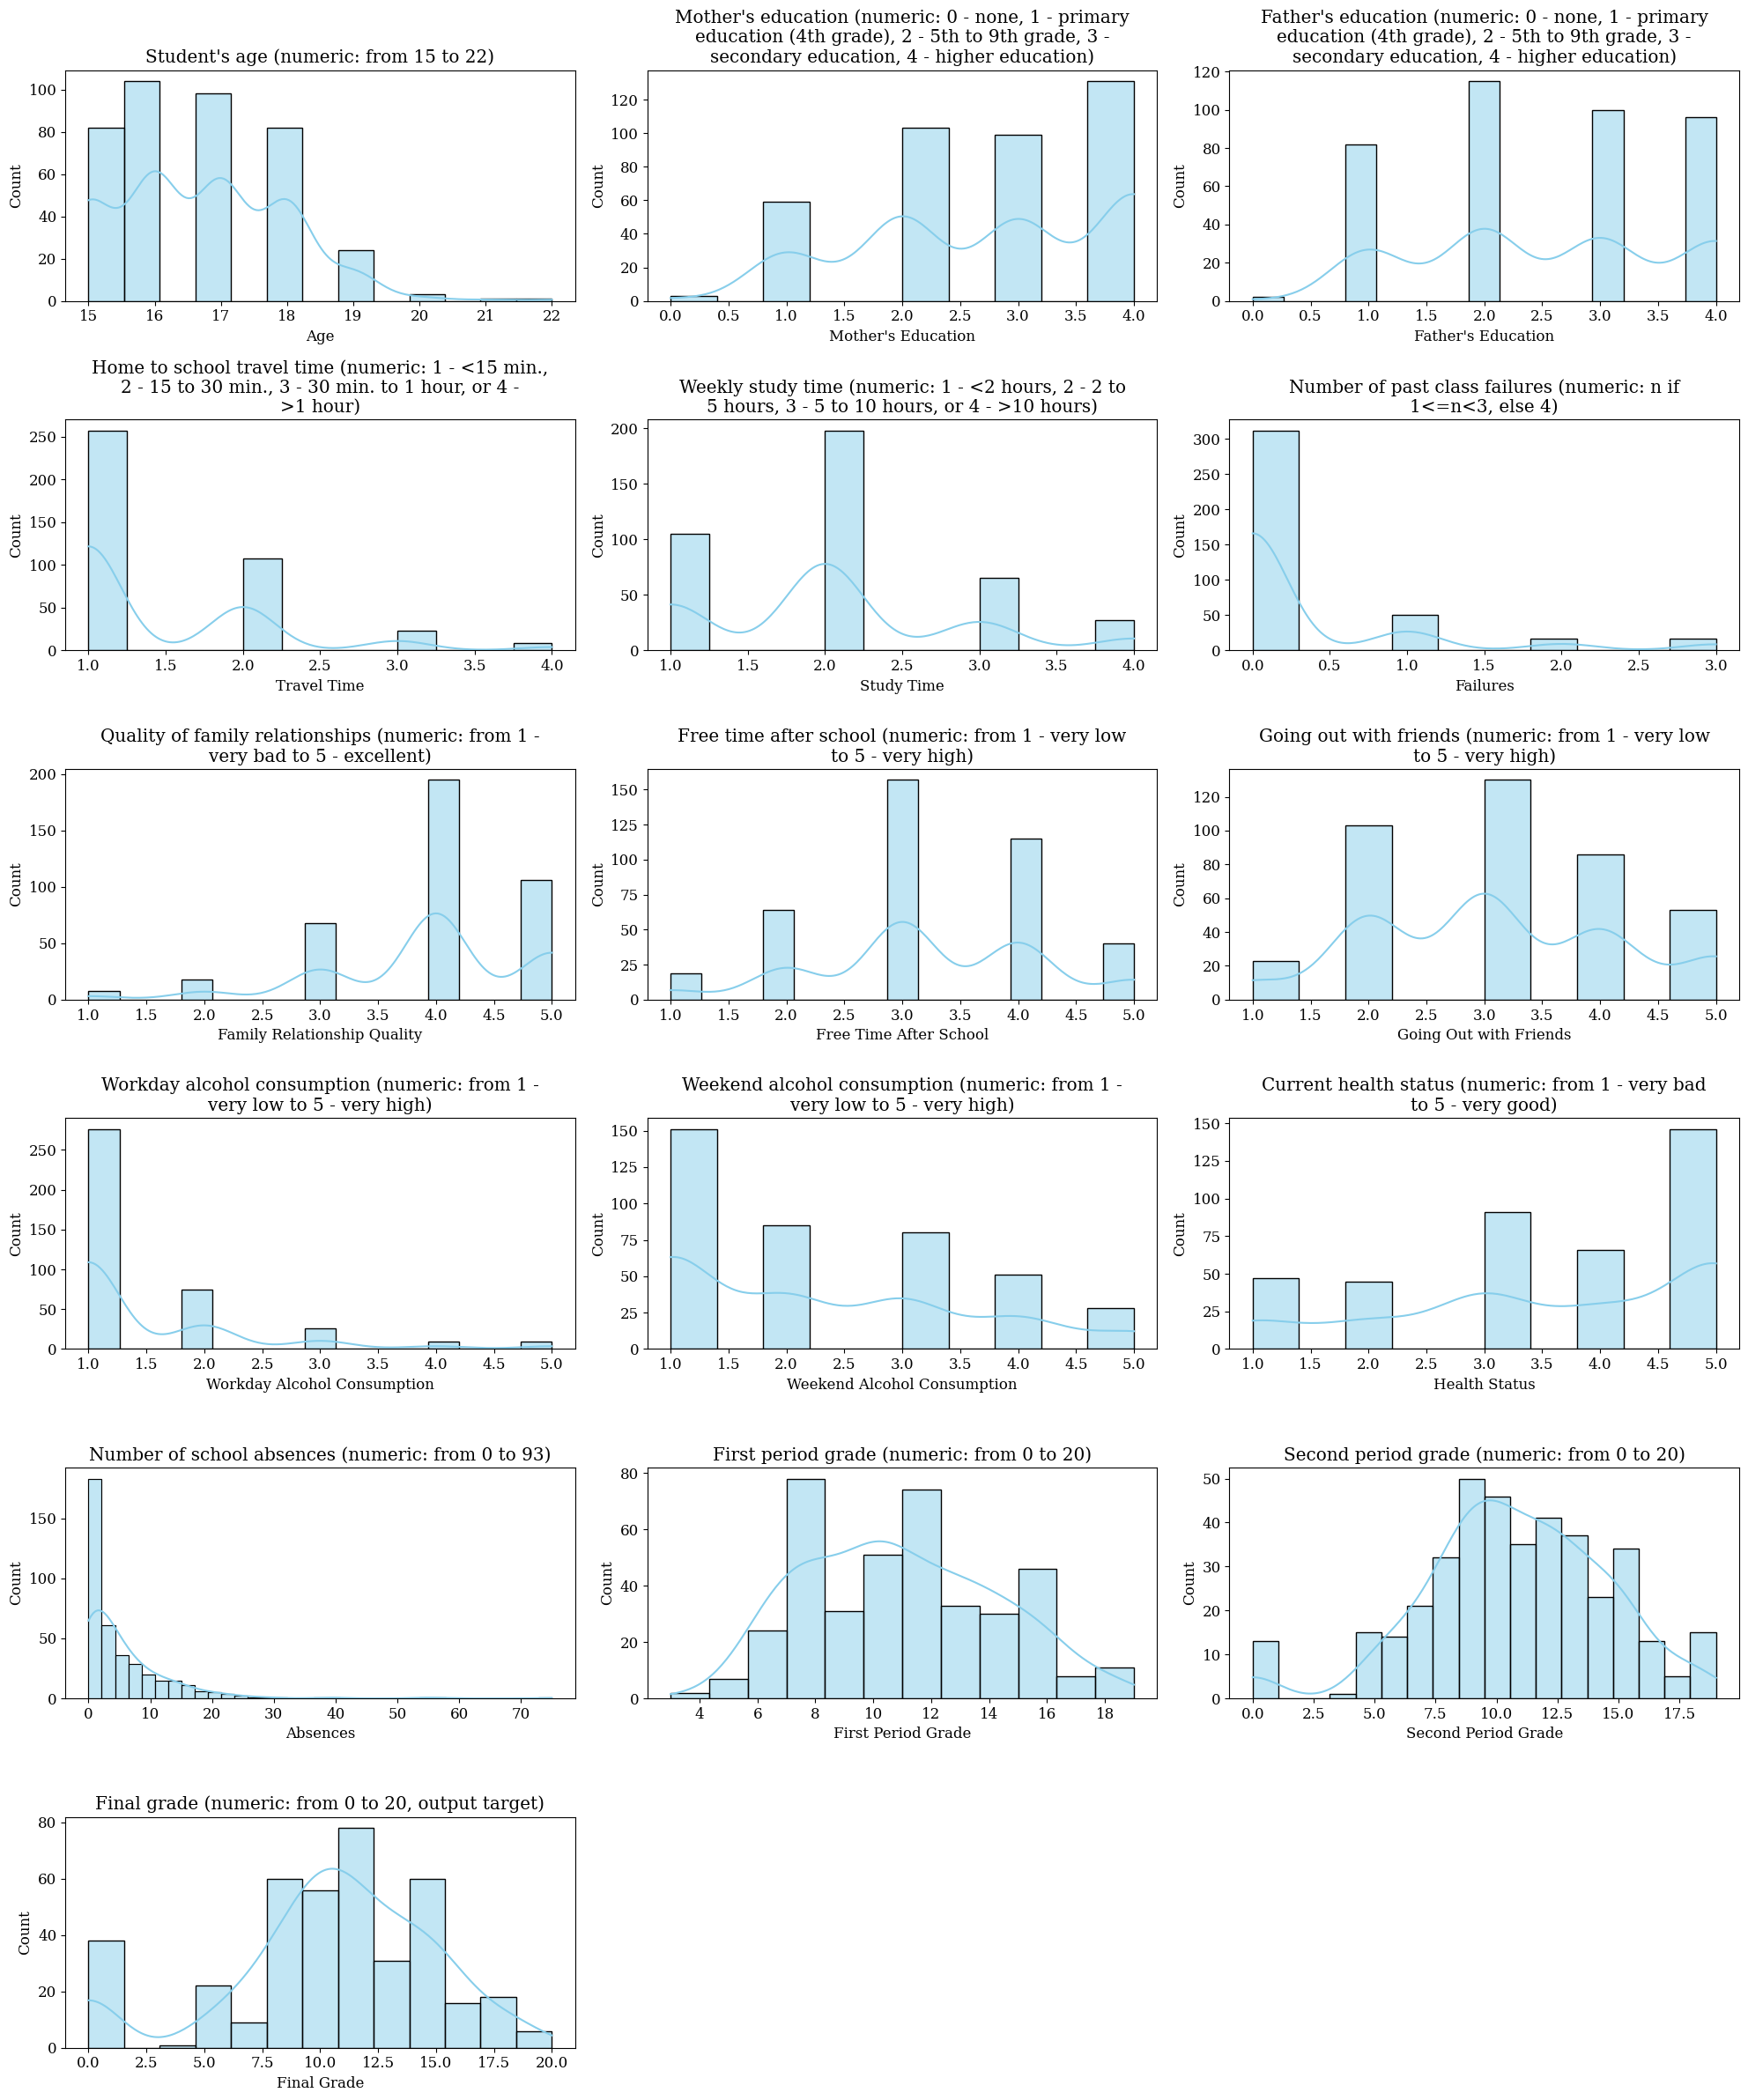

In [46]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])
plot_feature_distribution(numerical_data, feature_mapping)

**Distribution of Non-Numerical Features:**

The non-numerical features in this dataset include categorical and binary data that describe various qualitative aspects of the students' backgrounds:

- `school`: The school the student is attending (`GP` - Gabriel Pereira or `MS` - Mousinho da Silveira).
- `sex`: The gender of the student (`F` - female or `M` - male).
- `address`: The type of home address (`U` - urban or `R` - rural).
- `famsize`: The family size (`LE3` - less or equal to 3, or `GT3` - greater than 3).
- `Pstatus`: The cohabitation status of the student's parents (`T` - living together or `A` - apart).
- `Mjob`: The mother's job category (e.g., 'teacher', 'health', 'services', 'at_home', 'other').
- `Fjob`: The father's job category (e.g., 'teacher', 'health', 'services', 'at_home', 'other').
- `reason`: The reason for choosing the school (e.g., 'home', 'reputation', 'course', 'other').
- `guardian`: The student's guardian (`mother`, `father`, or `other`).
- `schoolsup`: Whether the student receives extra educational support (`yes` or `no`).
- `famsup`: Whether the student receives family educational support (`yes` or `no`).
- `paid`: Whether the student attends extra paid classes in the course subject (`yes` or `no`).
- `activities`: Participation in extra-curricular activities (`yes` or `no`).
- `nursery`: Whether the student attended nursery school (`yes` or `no`).
- `higher`: Whether the student intends to pursue higher education (`yes` or `no`).
- `internet`: Whether the student has internet access at home (`yes` or `no`).
- `romantic`: Whether the student is in a romantic relationship (`yes` or `no`).

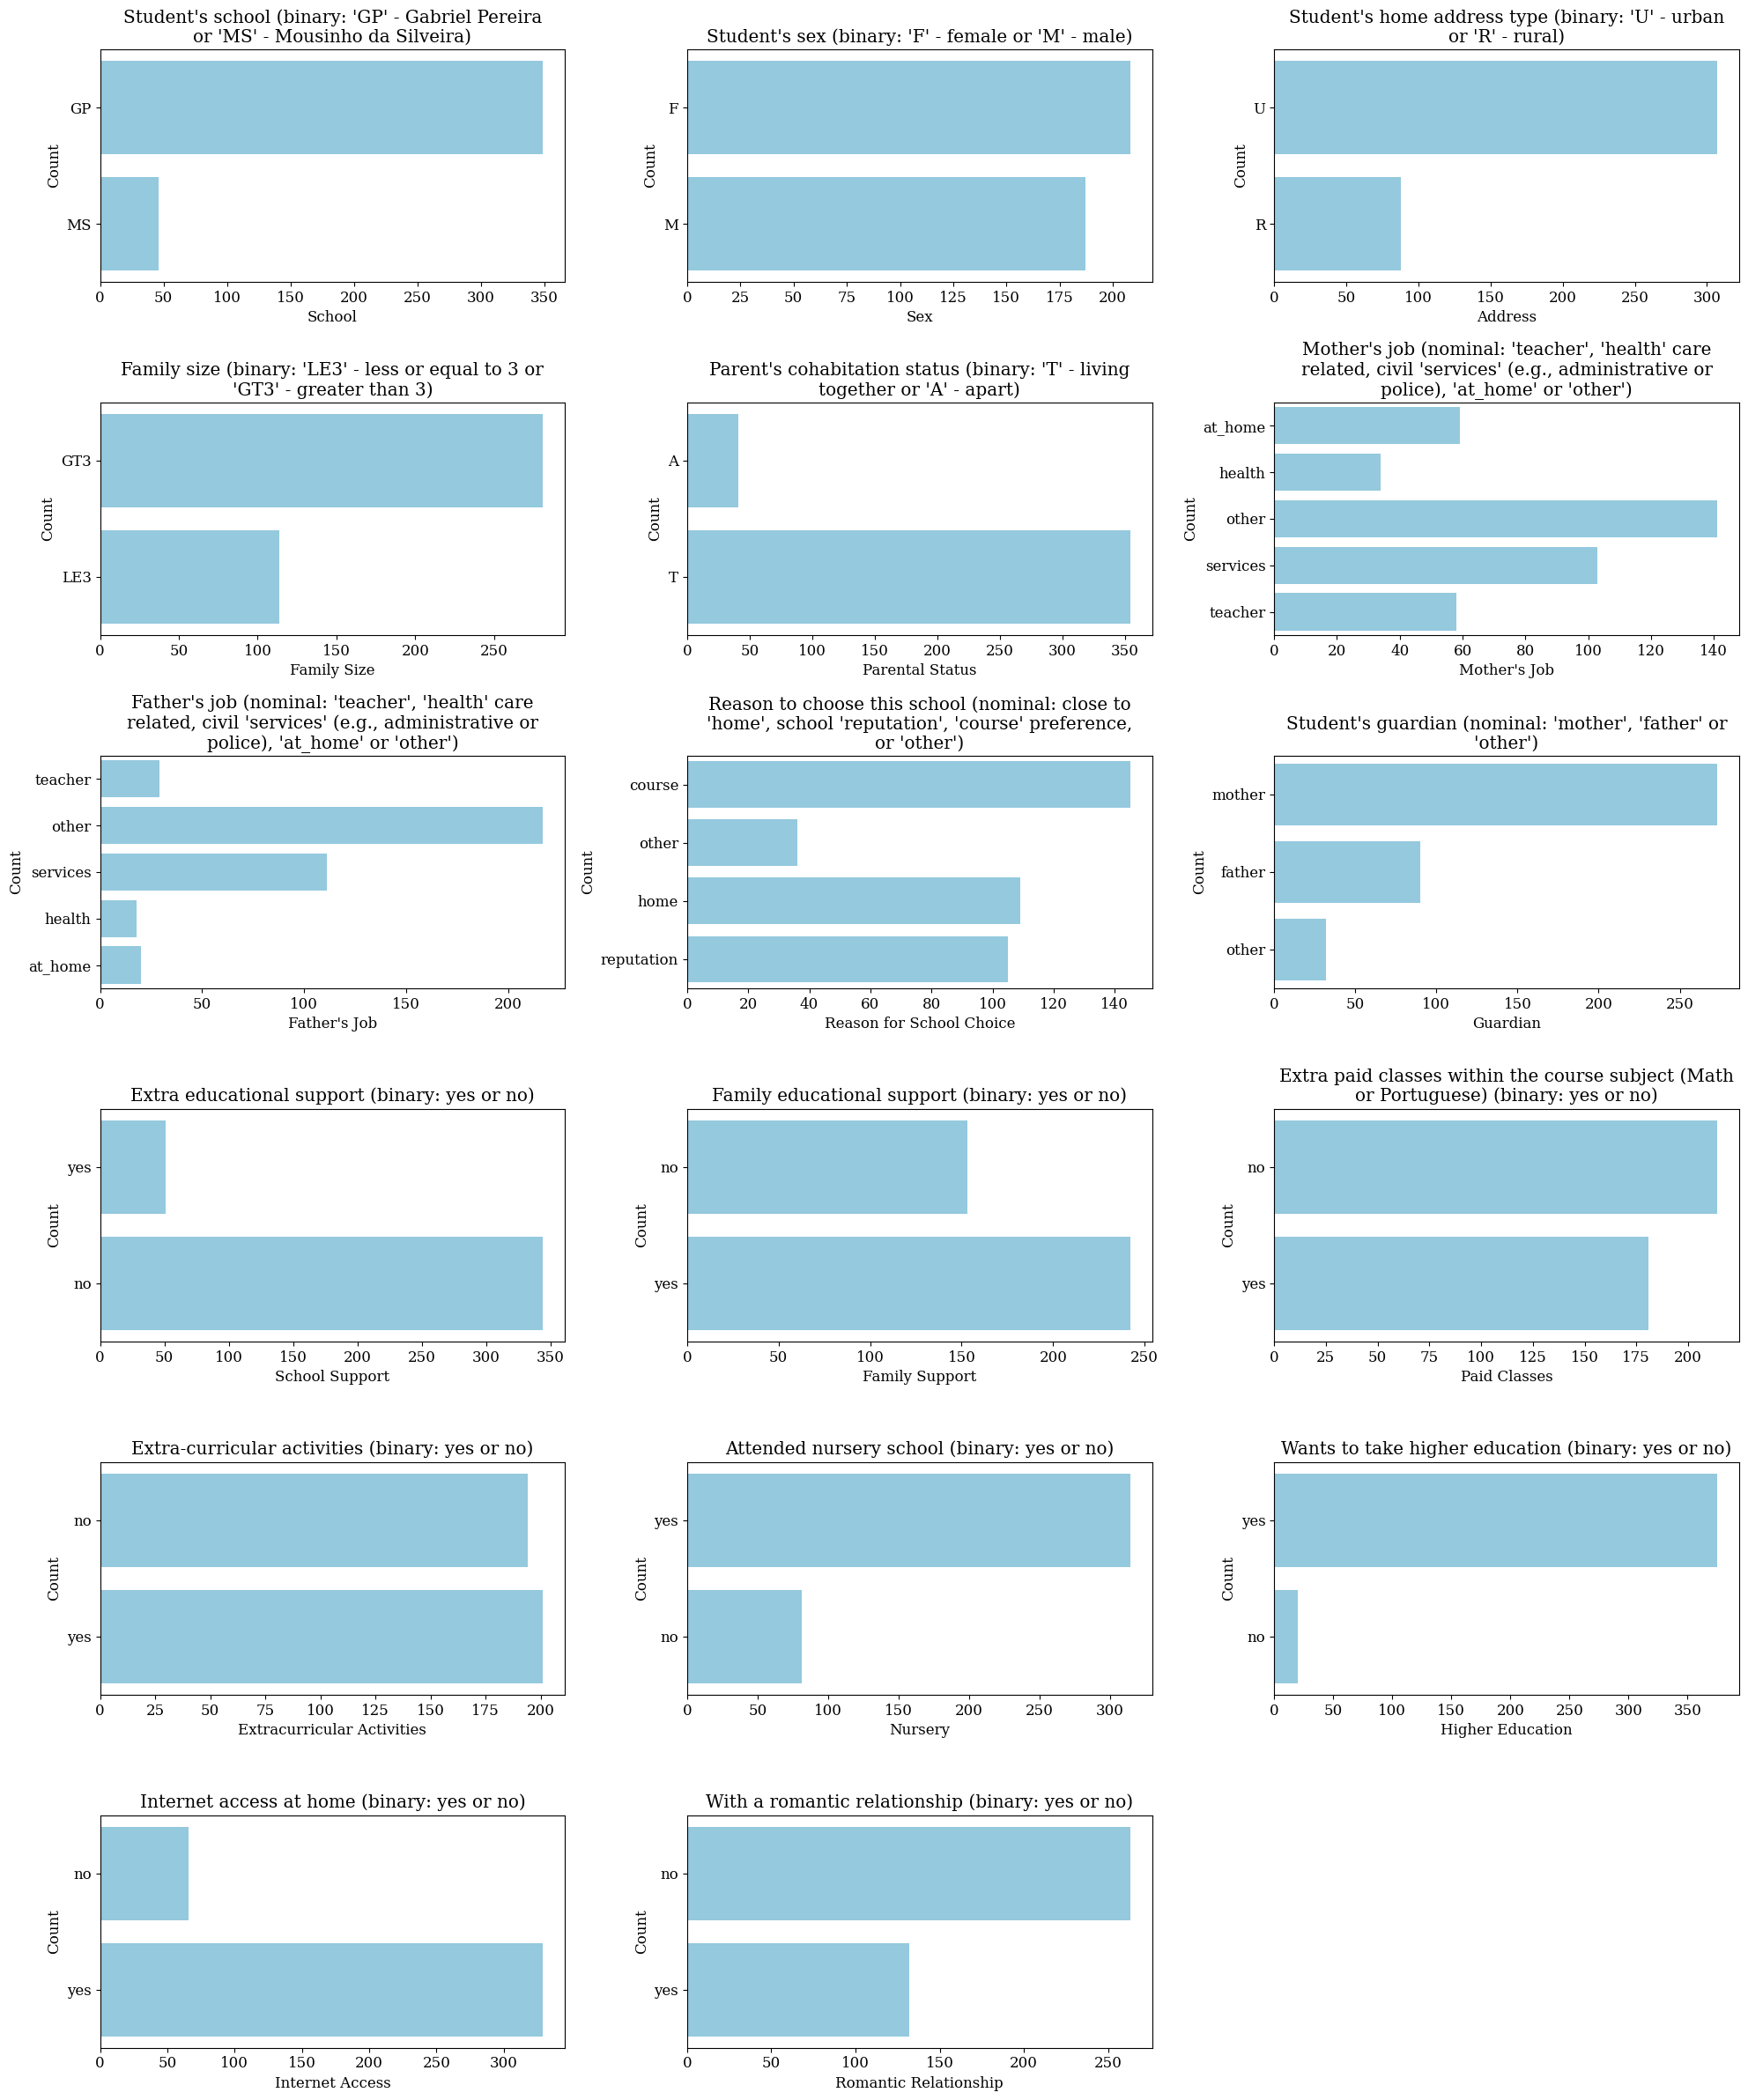

In [47]:
non_numerical_data = data.select_dtypes(exclude=['int64', 'float64'])
plot_feature_distribution(non_numerical_data, feature_mapping)

**Correlation Analysis**

To understand the relationships between different numerical features, we will create a correlation matrix and visualize it using a heatmap.

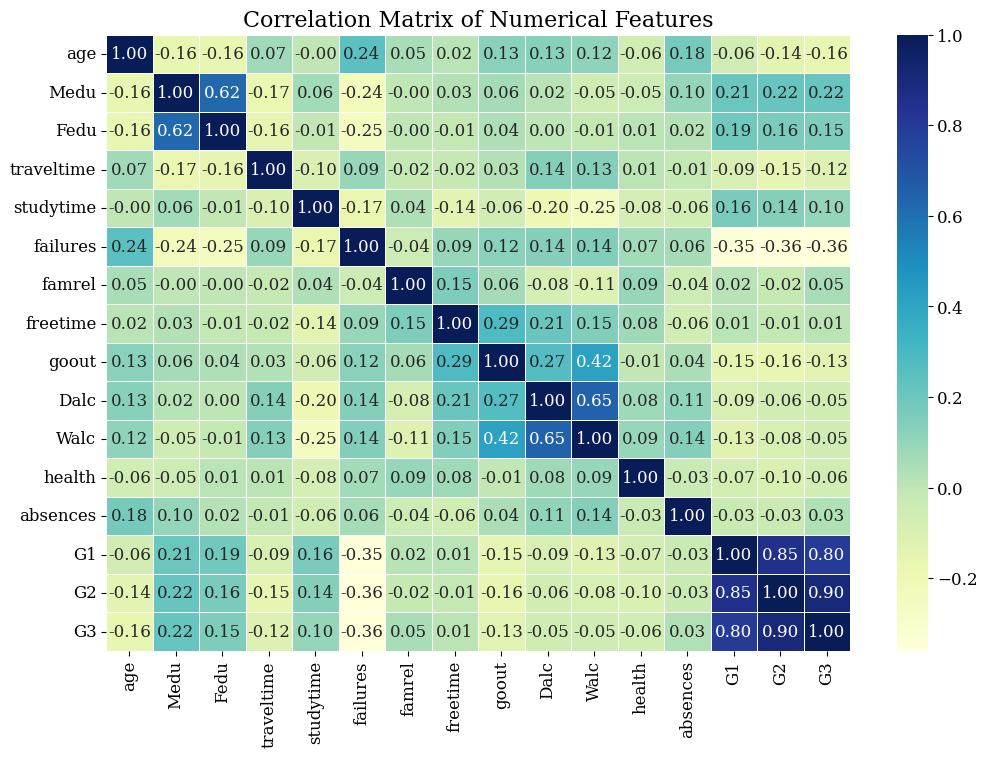

In [48]:
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=.5)

plt.title('Correlation Matrix of Numerical Features', size=16)
plt.show()


**Key Observations on the Numerical Correlation Matrix**

1. **Strong Positive Correlations:**
   - **`G1`, `G2`, and `G3`:** These grades are strongly positively correlated, with correlation coefficients ranging from 0.80 to 0.90. This strong relationship is expected, as these variables represent student grades across different periods. The consistency in a student's performance across these periods is evident.
   - **`Dalc` and `Walc`:** The correlation between workday and weekend alcohol consumption is notably high (0.65). This suggests that students who consume more alcohol during weekdays also tend to do so on weekends.

2. **Negative Correlations:**
   - **`failures` with `G1`, `G2`, and `G3`:** There is a strong negative correlation between the number of past class failures and current grades, with correlation coefficients around -0.35. This indicates that students with a history of academic failures tend to achieve lower grades.
   - **`goout` with `G1`, `G2`, and `G3`:** Moderate negative correlations are observed between the frequency of social outings and academic performance. This may imply that students who spend more time socializing tend to have slightly lower grades.

3. **Weak or No Correlations:**
   - **`age` with most other variables:** The student's age exhibits weak correlations with most other variables, suggesting that age does not significantly influence other aspects of the students' profiles in this dataset.
   - **`health` with academic performance:** The self-reported health status of students shows little to no correlation with their grades, indicating that health, as measured in this dataset, does not have a significant linear relationship with academic success.

4. **Other Noteworthy Correlations:**
   - **`Medu` (Mother's education) and `Fedu` (Father's education):** The education levels of the mother and father are fairly strongly correlated (0.62). This may indicate a tendency for parents with similar education levels to be together.
   - **`absences` with `G1`, `G2`, `G3`:** The number of absences shows a very weak correlation with grades, suggesting that absences alone are not a strong predictor of student performance. This finding could warrant further investigation.


Now, we also want to consider the nominal features, i.e., the features that cannot be ranked or quantified. We will use the `identify_nominal_columns` from the dython module to do this.
The code below lists all the nominal features in the dataset:

In [49]:
from dython.nominal import identify_nominal_columns
categorical_features = identify_nominal_columns(data)

print("Categorical features:")
features = ', '.join(categorical_features)
print("\n".join(wrap(features, 40)))

Categorical features:
school, sex, address, famsize, Pstatus,
Mjob, Fjob, reason, guardian, schoolsup,
famsup, paid, activities, nursery,
higher, internet, romantic


Now we can include these features and display a full correalation matrix for all features:

In [50]:
%%capture
complete_correlation = associations(data, figsize=(10,10));

In [51]:
df_complete_corr = complete_correlation['corr']
df_complete_corr.to_csv('analysis/complete_correlation_matrix.csv')

# Display the correlation matrix
df_complete_corr.style.background_gradient(
    cmap='YlGnBu', axis=None
).format(
    precision=2
).set_properties(**{'max-width': '30px', 'font-size': '10pt', 'text-align': 'center'})

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
school,1.00,0.00,0.38,0.27,0.02,0.00,0.13,0.08,0.02,0.11,0.15,0.03,0.24,0.09,0.06,0.12,0.15,0.00,0.10,0.06,0.00,0.11,0.01,0.05,0.03,0.01,0.11,0.07,0.04,0.09,0.03,0.05,0.05
sex,0.00,1.00,0.03,0.00,0.07,0.00,0.08,0.03,0.18,0.04,0.07,0.02,0.06,0.31,0.04,0.12,0.14,0.11,0.08,0.00,0.13,0.00,0.08,0.06,0.24,0.08,0.27,0.27,0.14,0.07,0.09,0.09,0.10
age,0.38,0.03,1.00,0.15,0.04,0.03,-0.16,-0.16,0.13,0.15,0.04,0.40,0.07,-0.00,0.24,0.25,0.14,0.04,0.10,0.09,0.21,0.11,0.16,0.05,0.02,0.13,0.13,0.12,-0.06,0.18,-0.06,-0.14,-0.16
address,0.27,0.00,0.15,1.00,0.04,0.00,0.14,0.07,0.15,0.00,0.13,0.04,0.33,0.02,0.08,0.00,0.00,0.00,0.00,0.01,0.00,0.20,0.00,0.01,0.03,0.07,0.09,0.10,0.04,0.03,0.07,0.13,0.11
famsize,0.02,0.07,0.04,0.04,1.00,0.13,0.04,0.06,0.00,0.00,0.00,0.00,0.06,0.07,0.02,0.00,0.09,0.00,0.00,0.08,0.00,0.00,0.00,0.02,0.02,0.02,0.10,0.10,0.03,0.04,0.07,0.08,0.08
Pstatus,0.00,0.00,0.03,0.00,0.13,1.00,0.12,0.09,0.00,0.04,0.00,0.09,0.03,0.02,0.00,0.00,0.00,0.00,0.07,0.06,0.00,0.03,0.00,0.03,0.04,0.00,0.03,0.01,0.02,0.13,0.02,0.04,0.06
Medu,0.13,0.08,-0.16,0.14,0.04,0.12,1.00,0.62,0.64,0.28,0.12,0.14,-0.17,0.06,-0.24,0.04,0.18,0.16,0.11,0.19,0.17,0.20,0.04,-0.00,0.03,0.06,0.02,-0.05,-0.05,0.10,0.21,0.22,0.22
Fedu,0.08,0.03,-0.16,0.07,0.06,0.09,0.62,1.00,0.36,0.41,0.05,0.13,-0.16,-0.01,-0.25,0.04,0.19,0.09,0.11,0.16,0.17,0.13,0.02,-0.00,-0.01,0.04,0.00,-0.01,0.01,0.02,0.19,0.16,0.15
Mjob,0.02,0.18,0.13,0.15,0.00,0.00,0.64,0.36,1.00,0.19,0.10,0.08,0.18,0.03,0.18,0.07,0.12,0.15,0.09,0.12,0.11,0.25,0.00,0.09,0.12,0.07,0.09,0.03,0.12,0.08,0.21,0.21,0.19
Fjob,0.11,0.04,0.15,0.00,0.00,0.04,0.28,0.41,0.19,1.00,0.06,0.11,0.14,0.14,0.11,0.07,0.08,0.00,0.00,0.07,0.00,0.03,0.00,0.10,0.11,0.06,0.12,0.19,0.09,0.04,0.19,0.12,0.11


**Key Observations on the Overall Correlation Matrix**


1. **Relationships Between Categorical Features and `G3`**

   - **Parental Occupations (`Mjob`, `Fjob`) and `G3`**: Both mother's job (Mjob) and father's job (Fjob) show notable relationships with the final grade (G3). While the exact correlations are not very high (0.19 for mother and 0.11 for father), the type of occupation parents hold may influence the academic environment and expectations at home.

   - **Extra-Curricular Activities (`activities`) and `G3`:** The correlation between participation in extra-curricular activities (`activities`) and `G3` is positive, though relatively weak (0.10). This suggests that students involved in activities outside of academics may slightly benefit in terms of their final grades. Engaging in extra-curricular activities could be associated with better time management skills or overall well-being, which might contribute to academic success.

   - **Study Time (`studytime`) and `G3`:** The study time variable (`studytime`) is positively correlated with `G3` (0.10). Although this is a modest correlation, it indicates that students who spend more time studying tend to achieve higher final grades. This relationship underscores the importance of consistent study habits in academic achievement.

   - **Romantic Relationships (`romantic`) and `G3`:** The presence of a romantic relationship (`romantic`) shows a slight negative correlation with `G3` (-0.13). This might suggest that students who are in relationships could have slightly lower academic performance, potentially due to the time and emotional investment required by relationships.


2. **Other Moderate to Strong Correlations:**

   - **`Medu` and `Mjob`, `Fedu` and `Fjob`:** There is a notable positive correlation between parents' education levels and their respective jobs (`Medu` and `Mjob`: 0.64, `Fedu` and `Fjob`: 0.41). This suggests that higher educational attainment is associated with more professional or administrative occupations for both mothers and fathers.

   - **`Pstatus` and `Medu`:** The correlation between parents' cohabitation status (`Pstatus`) and mother’s education level (`Medu`) is moderately positive (0.12). This might indicate that higher education among mothers is linked to greater parental stability or cohabitation.
  
   - **`activities` and `studytime`:** There is a moderate correlation (0.17) between students participating in extra-curricular activities and the amount of time they spend studying each week. This might suggest that students involved in activities manage their time to balance both academics and extracurriculars.


#### b. Decision-Making Based on EDA

**Model Selection:**

- **Linear Regression:** Linear Regression is selected due to its simplicity and the interpretability of its coefficients, which will help us understand the impact of key features like parental education (`Medu`, `Fedu`) and extra-curricular activities (`activities`) on the final grade (`G3`). Given the strong correlations between `G1`, `G2`, and `G3`, and the potential multicollinearity, we will drop `G1` and `G2` to focus solely on predicting `G3`. Accurately predicting the final grade without relying on previous grades provides more meaningful and practical insights, as it allows us to assess the impact of other educational and socio-economic factors independently.

- **Random Forest:** Random Forest is selected for its ability to handle the mixed nature of our dataset, which includes both categorical (e.g., `Mjob`, `Fjob`) and numerical features. Our EDA revealed that parental occupations and study habits are important predictors, and Random Forest’s feature importance scores will help us identify and rank these contributions. Additionally, its robustness against multicollinearity makes it ideal for retaining a broader set of features without the risk of overfitting.

- **Gradient Boosting:** The decision to include Gradient Boosting is driven by its strong performance in complex, imbalanced datasets like ours, where subtle relationships, such as those between parental jobs and `G3`, need to be captured. Our analysis showed that features like `studytime` and `activities` have modest but important correlations with `G3`, and Gradient Boosting’s sequential model-building approach is well-suited to iteratively refining the model to capture these patterns, particularly when there’s a risk of overfitting with more straightforward models.

**Data Cleaning and Preparation:**
- **Features to be Dropped:** We will first try to drop `G1` and `G2` due to their high correlation with `G3`, to avoid multicollinearity, particularly in Linear Regression. This ensures that our model's predictions focus on the broader range of factors affecting final grades, rather than relying heavily on previous grades.

- **Encoding and Scaling:** Categorical features will be one-hot encoded for Linear Regression and Gradient Boosting, while Random Forest can handle them natively but may still benefit from one-hot encoding. Numerical features will be standardized if necessary, ensuring consistent model performance across all algorithms.



#### c. Data Cleaning and Encoding

First, we drop the highly correlated features `G1` and `G2` to avoid multicollinearity, particularly when using Linear Regression.


In [52]:
data_previous_grades_dropped = data.drop(columns=['G1', 'G2'])

Next, we apply one-hot encoding to the categorical features to convert them into numerical format suitable for modeling, particularly for Linear Regression and Gradient Boosting.

In [53]:

# Apply one-hot encoding to the categorical features
data_cleaned = pd.get_dummies(data_previous_grades_dropped, columns=non_numerical_data.columns, drop_first=True)

# Check the resulting dataframe after encoding
data_cleaned.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False


### **3. Model Architecture** {-}

#### a. Initial model training


Here, we initialize our feature and target data and define the models we are going to use:

In [54]:
X = data_cleaned.drop(columns=['G3'])
y = data_cleaned['G3']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42))
]


Then we initiate the model training and evaluate the initial performance:

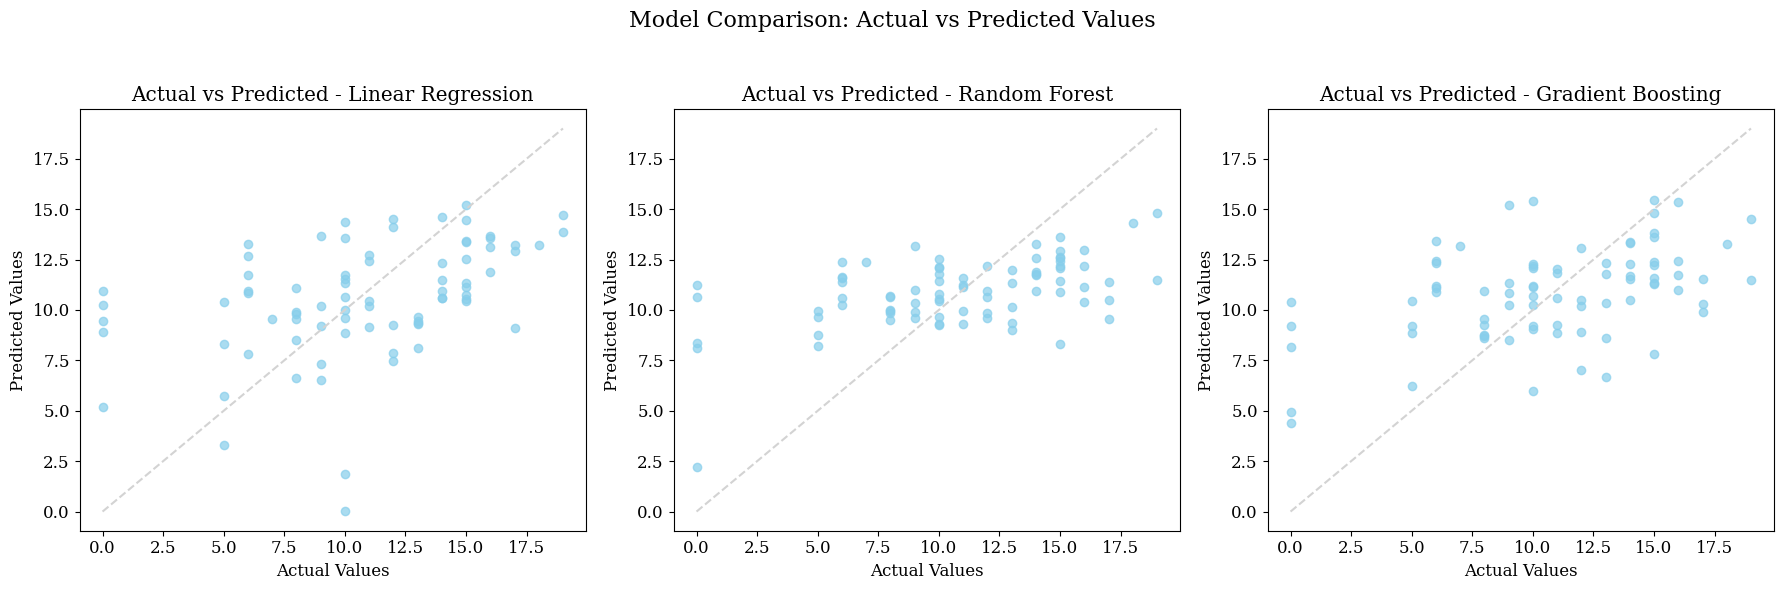

In [55]:
def evaluate_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, mae, r2, y_test, y_pred

def plot_model_results(y_test, y_pred, model_name, ax):
    ax.scatter(y_test, y_pred, alpha=0.7, color='skyblue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='lightgray', linestyle='--')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Actual vs Predicted - {model_name}')


def train_and_evaluate(X_train, X_test, y_train, y_test, models):
    model_metrics = []

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Model Comparison: Actual vs Predicted Values', fontsize=16)

    for i, (model_name, model_instance) in enumerate(models):
        model_instance.fit(X_train, y_train)
        mse, rmse, mae, r2, y_test, y_pred = evaluate_performance(model_instance, X_test, y_test)
        
        model_metrics.append({
            'Model': model_name,
            'Mean Squared Error': mse,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Error': mae,
            'R-squared': r2
        })
        
        # Plot the results
        plot_model_results(y_test, y_pred, model_name, axs[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return pd.DataFrame(model_metrics)

model_comparison_initial = train_and_evaluate(X_train, X_test, y_train, y_test, models)


#### b. Initial model performance


The dataframe below summarizes the performance of three regression models: Linear Regression, Random Forest, and Gradient Boosting. The metrics considered are Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).

In [56]:
model_comparison_initial.to_csv('analysis/model_comparison.csv', index=False)

model_comparison_initial

,Model,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,R-squared
0,Linear Regression,17.603737,4.195681,3.395261,0.141492
1,Random Forest,15.487262,3.935386,3.147722,0.244710
2,Gradient Boosting,16.214989,4.026784,3.234617,0.209220


**Key Observations:**

1. **R-squared (R²)**:
   - **Random Forest** achieved the highest R-squared value of **0.244710**, indicating that it explains about 24.47% of the variance in the data. While this is the best among the three models, it still suggests that over 75% of the variance in the target variable (`G3`) is not being captured by the model. This points to a significant limitation in the model’s ability to generalize from the training data to the test data.
   - **Gradient Boosting** and **Linear Regression** have even lower R-squared values, **0.209220** and **0.141492** respectively, which further underscores the models' inability to adequately explain the variance in student grades.

2. **Error Metrics (MSE, RMSE, MAE)**:
   - The error metrics (MSE, RMSE, and MAE) across all three models are relatively high, considering that student grades (`G3`) typically range between 0 and 20. For instance, an RMSE of around 4 implies that, on average, the predictions are off by 4 grade points, which is substantial given the scale of the grades.
   - Although **Random Forest** performs slightly better than the other models, with the lowest errors, the overall error levels indicate that none of the models are particularly accurate.

**Summary:**

The overall performance of these models is indeed poor. The low R-squared values suggest that a large portion of the variance in the final grades remains unexplained by the models. Additionally, the relatively high error metrics indicate that the models are not making very accurate predictions. This could be due to several factors:

- **Insufficient Features**: The features currently used might not capture the full range of factors that influence student grades. Important variables could be missing, or the relationships between features and the target variable might be more complex than what these models can capture.
  
- **Model Complexity**: The models may not be complex enough to capture the underlying patterns in the data, or conversely, they might be overfitting to noise in the training data.

- **Data Quality**: There may be issues with the quality of the data, such as noise, outliers, or inconsistencies that are impacting model performance.

In summary, while **Random Forest** is the best performer among the three, the overall model accuracy indicates room for improvement. To enhance predictive power, we will consider reintroducing `G1` and `G2`, as they are strong predictors of `G3`. But before that, we'll conduct feature selection by analyzing and dropping less relevant features that may be contributing noise to the model. 

#### c. Feature Selection and Corresponding Modeling


Given the previous poor performance, we can make the adjustments below:

- **Dropping Less Relevant Features**
  - **`famsize`, `Pstatus`, `famsup`, `paid`, `activities`, `nursery`, `romantic`, `famrel`**: These features have weak correlations with not only `G3`, but also with almost all other features. They likely add noise rather than valuable predictive information. Dropping them could model complexity and enhance focus on impactful predictors.

- **Combining Features**
  - **`freetime` + `goout` + `dalc` + `walc` + `absences`**: This composite feature represents the overall impact of social activities, behavior, and absences on grades, as they are all highly related to non-school activities. This relationship is also supported by their positive correlations observed in the previous analyses.

- **Adjusting Feature Weights Based on Guardian**
  - **Weight Adjustment for `Medu`,`Mjob`, `Fedu` and `Fjob`**: Adjusting the weight of these features based on the guardian better reflects the stronger influence of the guardian’s background on the student’s performance, enhancing the model's sensitivity to family dynamics.

We will compare these strategies and decide which strategies can be applied. The code block below defines these strategies.


In [57]:
ADJUSTMENT_FACTOR = 1.1

# 1. Dropping the specified features
def drop_features(data):
    features_to_drop = ['famsize', 'Pstatus', 'famsup', 'paid', 'activities', 'nursery', 'romantic', 'famrel']
    return data.drop(columns=features_to_drop)

# 2. Combine the social features into a single column
def combine_social_features(data):
    data['social'] = (
        data['freetime'] +
        data['goout'] +
        data['Dalc'] +
        data['Walc'] +
        data['absences']
    )
    return data.drop(columns=['freetime', 'goout', 'Dalc', 'Walc', 'absences'])

# 3. Adjust the weights of the parents' education based on the guardian
def adjust_parent_education_weights(data, adjustment_factor=ADJUSTMENT_FACTOR):
    data['Medu'] = data['Medu'].astype(float)
    data['Fedu'] = data['Fedu'].astype(float)
    
    data.loc[data['guardian'] == 'mother', 'Medu'] *= adjustment_factor
    data.loc[data['guardian'] == 'father', 'Fedu'] *= adjustment_factor
    
    return data



adjustments = [
    ('Drop Features', drop_features),
    ('Combine Social Features', combine_social_features),
    ('Adjust Parent Education Weights', adjust_parent_education_weights)
]

Now, we apply these approaches to the dataset and compare their performance.

In [58]:
adj_metrics = []

for adj_name, adj_func in adjustments:
    data_cleaned = data.copy().drop(columns=['G1', 'G2'])
    data_cleaned = adj_func(data_cleaned)
    data_cleaned = pd.get_dummies(data_cleaned, drop_first=True)

    X = data_cleaned.drop(columns=['G3'])
    y = data_cleaned['G3']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for model_name, model_instance in models:
        model_instance.fit(X_train, y_train)
        mse, rmse, mae, r2, y_test, y_pred = evaluate_performance(model_instance, X_test, y_test)
        adj_metrics.append({
            'Adjustment': adj_name,
            'Model': model_name,
            'Mean Squared Error': mse,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Error': mae,
            'R-squared': r2
        })

    model_comparison = pd.DataFrame(adj_metrics)


initial_dict = model_comparison_initial.to_dict(orient='records')
for item in initial_dict:
    item["Adjustment"] = "Initial"
    adj_metrics.append(item)

adj_df = pd.DataFrame(adj_metrics)
adj_df.to_csv('analysis/adjusment_comparison.csv', index=False)

adj_df


,Adjustment,Model,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,R-squared
0,Drop Features,Linear Regression,16.617246,4.076426,3.211507,0.189602
1,Drop Features,Random Forest,15.166091,3.894367,3.072405,0.260373
2,Drop Features,Gradient Boosting,15.784536,3.972976,3.081667,0.230212
3,Combine Social Features,Linear Regression,18.458922,4.296385,3.458077,0.099786
4,Combine Social Features,Random Forest,17.285842,4.157625,3.280633,0.156996
5,Combine Social Features,Gradient Boosting,19.017631,4.360921,3.480840,0.072539
6,Adjust Parent Education Weights,Linear Regression,17.568120,4.191434,3.392936,0.143229
7,Adjust Parent Education Weights,Random Forest,15.499735,3.936970,3.130000,0.244101
8,Adjust Parent Education Weights,Gradient Boosting,17.204483,4.147829,3.271327,0.160964
9,Initial,Linear Regression,17.603737,4.195681,3.395261,0.141492


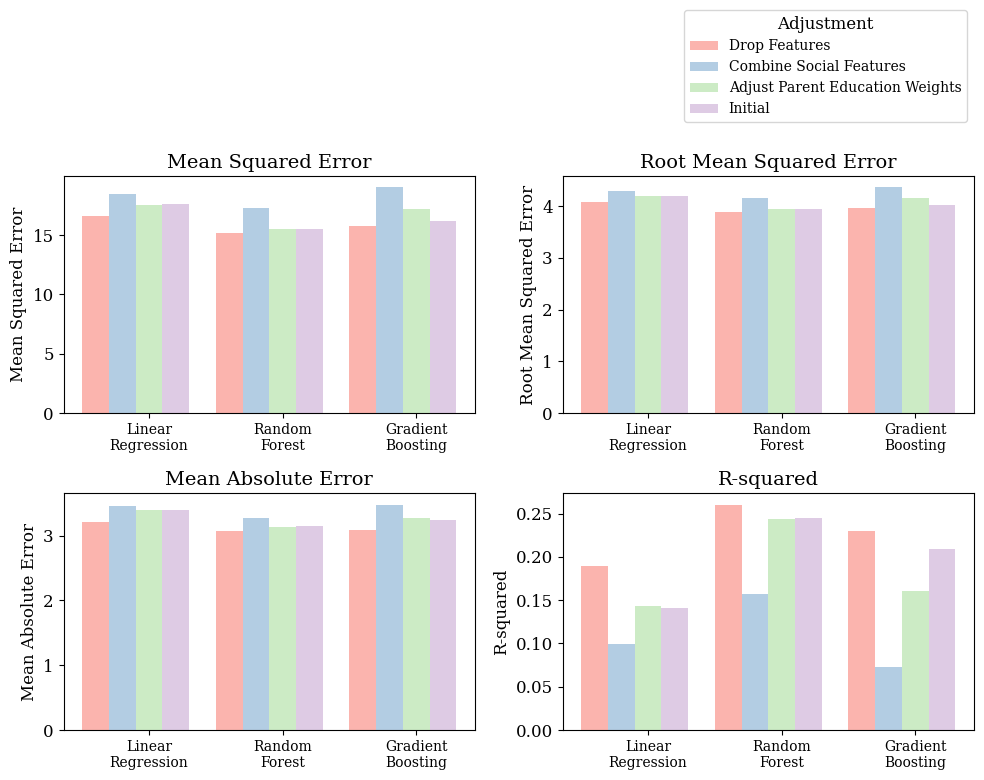

In [59]:
# Plotting the comparisons for each metric using side-by-side bars
adj_df = pd.DataFrame(adj_metrics)
metrics_to_plot = ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']


plt.clf()
plt.close('all')

colors = sns.color_palette("Pastel1", n_colors=len(adj_df['Adjustment'].unique()))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plotting
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i // 2, i % 2]

    bar_width = 0.2
    x = np.arange(len(adj_df['Model'].unique()))

    for j, adjustment in enumerate(adj_df['Adjustment'].unique()):
        subset = adj_df[adj_df['Adjustment'] == adjustment]
        ax.bar(x + j * bar_width, subset[metric].values, width=bar_width, label=adjustment, color=colors[j])
    
    ax.set_title(metric, fontsize=14)
    ax.set_xticks(x + bar_width * (len(adj_df['Adjustment'].unique()) / 2))
    ax.set_xticklabels([ '\n'.join(wrap(model, 10)) for model in adj_df['Model'].unique()], fontsize=10)
    ax.set_ylabel(metric, fontsize=12)

    
    if i == 1:
        ax.legend(title='Adjustment', loc='lower right', bbox_to_anchor=(1, 1.2), fontsize=10)
    else:
        ax.legend().set_visible(False)

plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.tight_layout()
plt.show()


**Comparisons of Different Strategies**

1. **Drop Features:**
   - This adjustment provided strong overall performance, with Random Forest achieving the highest R-squared (0.2604) and the lowest MSE (15.1661). Simplifying the model by removing less relevant features helped enhance accuracy and predictive power.

2. **Combine Social Features:**
   - This approach resulted in the weakest performance across all models. The combined social feature appeared to oversimplify important relationships, leading to higher errors and lower R-squared values, particularly in Gradient Boosting.

3. **Adjust Parent Education Weights:**
   - Adjusting parental education weights based on the guardian resulted in slight improvements over the initial model for Linear Regression, but it did not outperform the `Drop Features` strategy. The R-squared values and errors were still lagged behind the initial model for Random Forest and Gradient Boosting.

The `Drop Features` adjustment emerges as the most effective strategy, particularly when using the Random Forest model. It optimizes performance and should be the preferred approach for further refinement and predictive analysis.


#### d. Further Improvements


To further refine our model, we will integrate the `G1` and `G2` scores, which are strong predictors of the final grade `G3`, and drop other less relevant features. The key steps include:

- **Integrate `G1` and `G2` Scores:** Include the `G1` and `G2` scores back into the dataset, as they provide significant predictive power for the final grade `G3`.

- **Drop Less Relevant Features:** Drop the features identified as less relevant (`famsize`, `Pstatus`, `famsup`, `paid`, `activities`, `nursery`, `romantic`, `famrel`) to streamline the model.

- **Final Model Training:** Train the final model using the updated dataset with `G1` and `G2` integrated and the less relevant features removed.

Despite our efforts to accurately predict `G3` without previous grades, the model still relies heavily on these features to enhance prediction accuracy. While the inclusion of `G1` and `G2` improves the model, the prediction of `G3` remains complex and influenced by a broader range of factors.


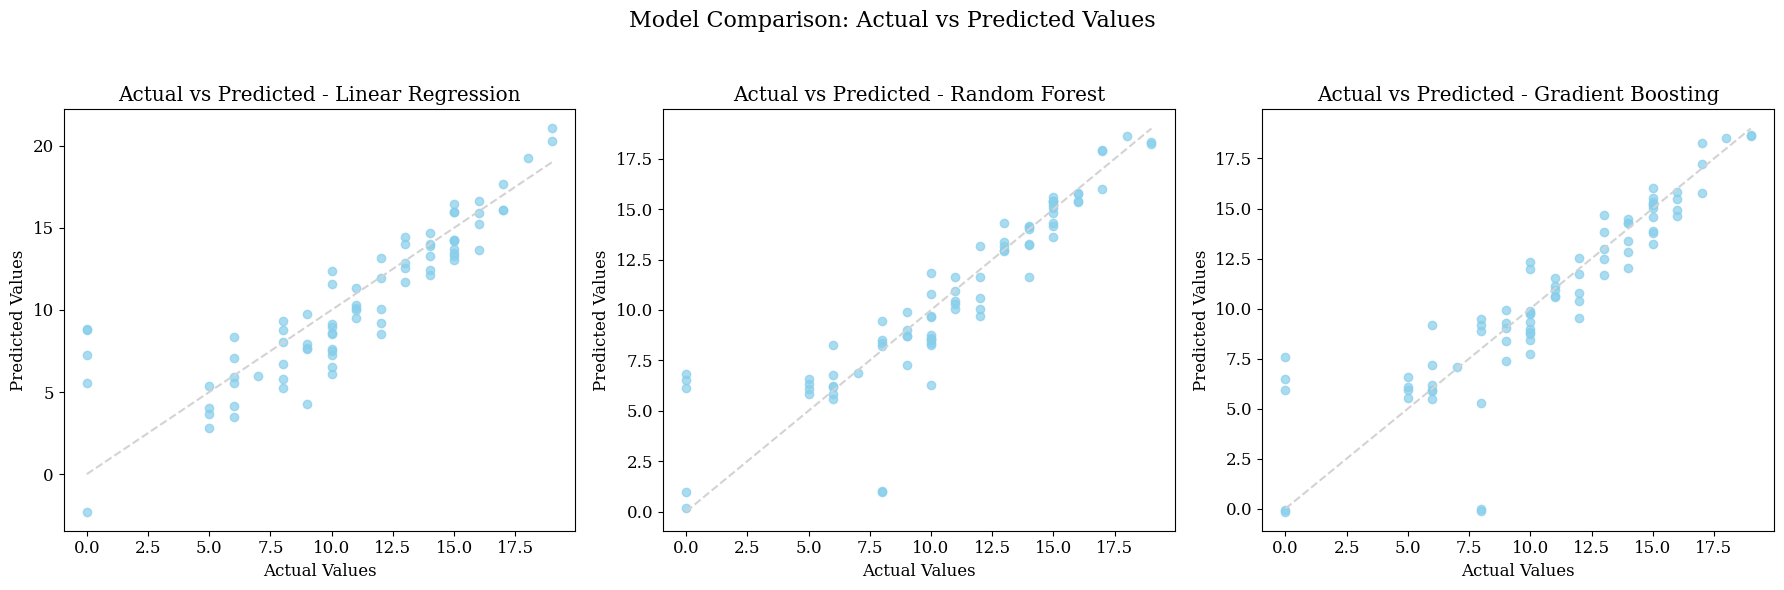

In [60]:
data_cleaned = drop_features(data.copy())
data_cleaned = pd.get_dummies(data_cleaned, drop_first=True)

X = data_cleaned.drop(columns=['G3'])
y = data_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_comparison_result = train_and_evaluate(X_train, X_test, y_train, y_test, models)
model_comparison_result.to_csv('analysis/model_comparison_result.csv', index=False)

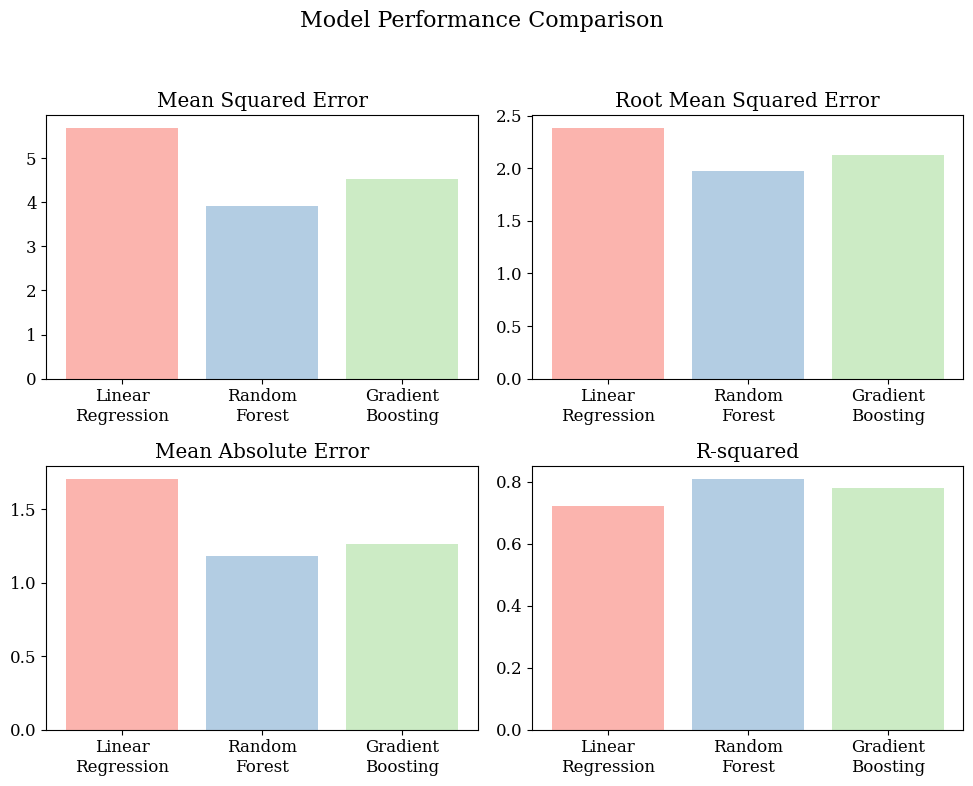

In [61]:
colors = sns.color_palette("Pastel1", n_colors=len(model_comparison_result['Model']))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Define the metrics to plot and their respective y-axis labels
metrics_to_plot = {
    'Mean Squared Error': 'Mean Squared Error',
    'Root Mean Squared Error': 'Root Mean Squared Error',
    'Mean Absolute Error': 'Mean Absolute Error',
    'R-squared': 'R-squared'
}

# Iterate over the metrics and corresponding axes
for ax, (metric, _) in zip(axes.flatten(), metrics_to_plot.items()):
    ax.bar(
        [ '\n'.join(wrap(model, 10)) for model in model_comparison_result['Model']],
        model_comparison_result[metric],
        color=colors
    )
    ax.set_title(metric)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 4. Conclusion {-}

In this analysis, we aimed to predict the `G3` (final grade) of students by exploring various feature selection and engineering strategies. We tested multiple models, including Linear Regression, Random Forest, and Gradient Boosting, to determine the most effective approach for improving predictive accuracy.

#### 1. Exploratory Data Analysis (EDA)

Through EDA, we gained initial insights into the data distribution, correlations, and potential relationships between features and the target variable `G3`. Key findings included strong correlations between previous grades (`G1`, `G2`) and the final grade (`G3`), and the potential noise contributed by non-academic features.

#### 2. Comparisons of Models

We compared the performance of Linear Regression, Random Forest, and Gradient Boosting models. Among these, Random Forest consistently outperformed the others, particularly in terms of R-squared value, indicating its superior ability to capture complex relationships within the data. This model's performance underscored the importance of using ensemble methods for predictive tasks in education.

#### 3. Comparisons of Feature Selection Strategies

We evaluated several feature selection strategies, including dropping less relevant features, combining social features, and adjusting parent education weights. The `Drop Features` strategy emerged as the most effective, particularly when paired with the Random Forest model. This approach reduced noise and improved the model's focus on impactful predictors, leading to better overall performance.

#### 4. Final Modeling

In the final stage, we integrated `G1` and `G2` scores and refined the model using the `Drop Features` strategy. This combination led to the best results, with Random Forest achieving an R-squared of 0.81. However, despite these improvements, predicting final grades (`G3`) without the inclusion of `G1` and `G2` remains an ideal but challenging goal. The results indicate that while accurate predictions are possible, the model's performance heavily relies on carefully selected features, and excluding `G1` and `G2` would require further refinement.

### Final Thoughts {-}

The Random Forest model, combined with the `Drop Features` adjustment, proved to be the most effective strategy. However, the model's reliance on various features suggests that predicting `G3` accurately requires a careful balance of feature selection and modeling techniques.

One significant observation from the results is that the predictions of final grades around 0 are particularly inaccurate. This inaccuracy may stem from the lack of sufficient samples within this grade range in the dataset, leading to poor model generalization in this area. When data is sparse, models struggle to capture the nuances required to make accurate predictions, which can be especially problematic for identifying students at the lowest performance levels.

Predicting final grades without relying on `G1` and `G2` might seem idealistic, especially when training with a relatively small dataset, yet it remains an essential goal in the education industry. Achieving this would provide valuable insights for educational interventions and personalized learning. Overall, the work highlights the importance of strategic feature selection and the effectiveness of ensemble models like Random Forest in handling complex predictive tasks.


### Citations {-}

- Knoldus. (2018, August 8). How to find correlation value of categorical variables. *Medium*. https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26

- Cortez, P., & Silva, A. M. G. (2008). Using data mining to predict secondary school student performance. In A. Brito & J. Teixeira (Eds.), *Proceedings of 5th Annual Future Business Technology Conference* (pp. 5-12). UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Student+Performance

- Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. *Computers & Electrical Engineering, 40*(1), 16-28. https://doi.org/10.1016/j.compeleceng.2013.11.024

- Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. *Annals of Statistics, 29*(5), 1189-1232. https://doi.org/10.1214/aos/1013203451
